# Decision Tree & Random Forest for WU Data

## Import Packages

In [247]:
import numpy as np
import pandas as pd
import random
import datetime
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as sm
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.tree import plot_tree
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingRegressor
from sklearn.svm import LinearSVR
from sklearn.svm import SVR
from prettytable import PrettyTable

# Ignore useless warnings 
import warnings
warnings.filterwarnings(action="ignore")    


In [248]:
import os
os.getcwd()

'/Users/danny/Desktop/MDS/master 4/CITS 5553 Data Science Capstone Project/Individual/Capstone-Individual/Data'

## Read Data

In [249]:
os.chdir('/Users/danny/Desktop/MDS/master 4/CITS 5553 Data Science Capstone Project/Individual/Capstone-Individual/Data')

In [250]:
df = pd.read_csv('aemo_wu_merged.csv', index_col = 0)
df.head()

,timestamp,Operational Demand (MW),temperature(celcius),dew_point(celcius),humidity(%),Wind,wind_speed(mph),wind_gush(mph),pressure(in),precip.(in),Condition
0,2017-01-22 00:00:00,1815.214,20.0,15.0,73.0,SSW,9.0,0.0,29.0,0.0,Fair
1,2017-01-22 00:30:00,1777.040,20.0,15.0,73.0,SSW,10.0,0.0,29.0,0.0,Fair
2,2017-01-22 01:00:00,1745.448,18.9,15.0,78.0,SSW,9.0,0.0,29.0,0.0,Fair
3,2017-01-22 01:30:00,1729.164,18.9,15.0,78.0,SSW,15.0,0.0,29.0,0.0,Fair
4,2017-01-22 02:00:00,1714.276,18.9,12.8,68.0,SSW,18.0,0.0,29.0,0.0,Fair


In [251]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97504 entries, 0 to 97503
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   timestamp                97504 non-null  object 
 1   Operational Demand (MW)  97504 non-null  float64
 2   temperature(celcius)     97504 non-null  float64
 3   dew_point(celcius)       97504 non-null  float64
 4   humidity(%)              97504 non-null  float64
 5   Wind                     97504 non-null  object 
 6   wind_speed(mph)          97504 non-null  float64
 7   wind_gush(mph)           97504 non-null  float64
 8   pressure(in)             97504 non-null  float64
 9   precip.(in)              97504 non-null  float64
 10  Condition                97504 non-null  object 
dtypes: float64(8), object(3)
memory usage: 8.9+ MB


In [252]:
df.columns

Index(['timestamp', 'Operational Demand (MW)', 'temperature(celcius)',
       'dew_point(celcius)', 'humidity(%)', 'Wind', 'wind_speed(mph)',
       'wind_gush(mph)', 'pressure(in)', 'precip.(in)', 'Condition'],
      dtype='object')

## Data Preparation

In [253]:
# Seperate timestamp and set several new variables
def wind_ans(x):
    if x > 0: 
        return 1 
    else:
        return 0
# split time into date and interval timedf['Date'] = pd.to_datetime(df['Date'])
df[['Date','Trading Interval Time']] = df['timestamp'].str.split(" ",expand=True)
df['Date'] = pd.to_datetime(df['Date'])
df['new_timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df['year'] = df['new_timestamp'].dt.year
df['month'] = df['new_timestamp'].dt.month
df['day'] = df['new_timestamp'].dt.day
df['hour'] = df['new_timestamp'].dt.hour
df['minute'] = df['new_timestamp'].dt.minute
df['Day_of_week'] = df['new_timestamp'].dt.dayofweek
df['Day_of_month'] = df['new_timestamp'].dt.day
df['Day_of_year'] = df['new_timestamp'].dt.dayofyear
df['has_Wind'] = df['wind_speed(mph)'].apply(wind_ans) 
df.set_index('timestamp', inplace=True, drop=True)
df.reset_index(inplace=True)
df.head()

,timestamp,Operational Demand (MW),temperature(celcius),dew_point(celcius),humidity(%),Wind,wind_speed(mph),wind_gush(mph),pressure(in),precip.(in),...,new_timestamp,year,month,day,hour,minute,Day_of_week,Day_of_month,Day_of_year,has_Wind
0,2017-01-22 00:00:00,1815.214,20.0,15.0,73.0,SSW,9.0,0.0,29.0,0.0,...,2017-01-22 00:00:00,2017,1,22,0,0,6,22,22,1
1,2017-01-22 00:30:00,1777.040,20.0,15.0,73.0,SSW,10.0,0.0,29.0,0.0,...,2017-01-22 00:30:00,2017,1,22,0,30,6,22,22,1
2,2017-01-22 01:00:00,1745.448,18.9,15.0,78.0,SSW,9.0,0.0,29.0,0.0,...,2017-01-22 01:00:00,2017,1,22,1,0,6,22,22,1
3,2017-01-22 01:30:00,1729.164,18.9,15.0,78.0,SSW,15.0,0.0,29.0,0.0,...,2017-01-22 01:30:00,2017,1,22,1,30,6,22,22,1
4,2017-01-22 02:00:00,1714.276,18.9,12.8,68.0,SSW,18.0,0.0,29.0,0.0,...,2017-01-22 02:00:00,2017,1,22,2,0,6,22,22,1


In [254]:
# def create_time_features(df_in):
#     df = df_in
#     df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
#     df['Year'] = df['timestamp'].dt.year
#     df['Month'] = df['timestamp'].dt.month
#     df['Hour'] = df['timestamp'].dt.hour
#     df['Day_of_week'] = df['timestamp'].dt.dayofweek
#     df['Day_of_month'] = df['timestamp'].dt.day
#     df['Day_of_year'] = df['timestamp'].dt.dayofyear
#     df.set_index('timestamp', inplace=True, drop=True)
#     # df = df.astype('int')
#     df.reset_index(inplace=True)
#     time_features_df = df
#     return time_features_df
# df_a = create_time_features(df)
# df_a.columns.tolist()
# df_a.head()

In [255]:
#select_col=['Operational Demand (MW)', 'temperature(celcius)', 'dew_point(celcius)', 'humidity(%)', 'wind_speed(mph)', 'year','Day_of_week','Day_of_month','Day_of_year']
df.index = df['timestamp']
select_col = ['Operational Demand (MW)', 'temperature(celcius)', 'dew_point(celcius)', 'humidity(%)', 'wind_speed(mph)', 'wind_gush(mph)', 'pressure(in)',
'Day_of_week', 'Day_of_month', 'Day_of_year','year','hour','minute']
y_col=['Operational Demand (MW)']
x_col=list(set(select_col)-set(y_col))
model_df=df[select_col]
# training_dat = model_df[(model_df.index < '2020-12-01') | ('2021-04-01' <= model_df.index)]
training_dat = model_df[model_df.index < '2021-12-01']
testing_dat = model_df[(model_df.index >= '2021-12-01') & ('2022-04-01' > model_df.index)]

X_train = training_dat.drop('Operational Demand (MW)',axis=1)
y_train = training_dat['Operational Demand (MW)']

X_test = testing_dat.drop('Operational Demand (MW)', axis = 1) 
y_test = testing_dat['Operational Demand (MW)']


## Function Preparation

In [256]:
def ModelScore(true,predict):
    print("Mean absolute error = ",round(sm.mean_absolute_error(true,predict),4))
    print("Mean squared error = ",round(sm.mean_squared_error(true,predict),4))
    print("Median absolute error = ",round(sm.median_absolute_error(true,predict),4))
    print("explained variance error = ",round(sm.explained_variance_score(true,predict),4))
    print("R2 error = ",round(sm.r2_score(true,predict),4))

def ImportanceDisplay(model):
    if 'grid' in model:
        impo_lst=[model,'.best_estimator_.feature_importances_']
    else:
        impo_lst=[model,'.feature_importances_']
    impo_str=''
    importance = eval(impo_str.join(impo_lst))
    #importance = rf_reg.feature_importances_
    table = PrettyTable(['Factors','Score'])
    for i,v in enumerate(importance):
	    table.add_row([x_col[i],round(v,4)])
    print(table)

## Feature Scale

In [257]:
# stdsc=StandardScaler()
# X_train_sc = stdsc.fit_transform(X_train)
# X_test_sc = stdsc.transform(X_test)

## Threshold Determine

125225.874

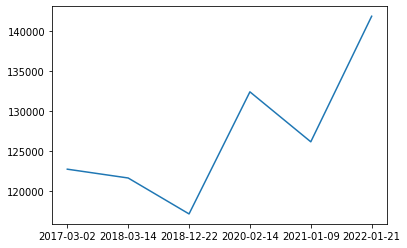

In [277]:
agg_all = model_df.copy()
agg_all['Date','time'] = agg_all.index.str.split(" ",expand=True)
agg_all[['Date', 'time']] = agg_all[('Date', 'time')].apply(pd.Series)

agg_all = agg_all.drop(labels=['time',('Date','time')], axis=1)
agg_all = pd.DataFrame(agg_all.groupby(['Date'])['Operational Demand (MW)'].sum())
new_df_summer = pd.DataFrame()
for i in range(2009,2022):
    s0 = str(i) + '-12-01'
    s1 = str(i+1) + '-04-01'
    df_summer = agg_all[(agg_all.index >= s0) & (s1 > agg_all.index)]
    order_table = df_summer.sort_values('Operational Demand (MW)',ascending=False)
    nr = order_table[3:4]
    new_df_summer = pd.concat((new_df_summer,nr))
od = new_df_summer['Operational Demand (MW)']
plt.plot(od.index,od)
year_choose = 3 # number of year we choose to get the average threshold
ave_threshold = sum(od[-4:-1])/year_choose
# ave_threshold= sum(od[:-1])/len(od[:-1])   
ave_threshold # same result for both threshold

In [259]:
od[:-1]

Date
2017-03-02    122727.980
2018-03-14    121625.992
2018-12-22    117137.326
2020-02-14    132391.970
2021-01-09    126148.326
Name: Operational Demand (MW), dtype: float64

## Decision Tree

In [260]:
tree_reg = DecisionTreeRegressor(criterion='mse', random_state=42)

param_grid_dtree = dict(
    max_depth =[None,15,20,25],
    min_samples_leaf=[5,50,100])

grid_dtree=GridSearchCV(tree_reg, param_grid_dtree, cv=3, scoring='neg_root_mean_squared_error',verbose=2,return_train_score=True)

grid_dtree.fit(X_train,y_train)
y_pred_tree = grid_dtree.predict(X_test)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END .................max_depth=None, min_samples_leaf=5; total time=   0.2s
[CV] END .................max_depth=None, min_samples_leaf=5; total time=   0.2s
[CV] END .................max_depth=None, min_samples_leaf=5; total time=   0.2s
[CV] END ................max_depth=None, min_samples_leaf=50; total time=   0.2s
[CV] END ................max_depth=None, min_samples_leaf=50; total time=   0.2s
[CV] END ................max_depth=None, min_samples_leaf=50; total time=   0.2s
[CV] END ...............max_depth=None, min_samples_leaf=100; total time=   0.1s
[CV] END ...............max_depth=None, min_samples_leaf=100; total time=   0.1s
[CV] END ...............max_depth=None, min_samples_leaf=100; total time=   0.1s
[CV] END ...................max_depth=15, min_samples_leaf=5; total time=   0.2s
[CV] END ...................max_depth=15, min_samples_leaf=5; total time=   0.2s
[CV] END ...................max_depth=15, min_sa

In [261]:
dtscore=ModelScore(y_test,y_pred_tree)
dtscore
ny_test=len(y_test)
mape = (sum(np.abs((y_test - y_pred_tree)/y_test))/ny_test)*100
print('Mape', mape)
ImportanceDisplay('grid_dtree')
print(grid_dtree.best_estimator_)

Mean absolute error =  255.6035
Mean squared error =  139813.4322
Median absolute error =  163.6055
explained variance error =  0.5934
R2 error =  0.5572
Mape 11.26563949984298
+----------------------+--------+
|       Factors        | Score  |
+----------------------+--------+
|     humidity(%)      | 0.2174 |
|   wind_speed(mph)    | 0.0337 |
|     pressure(in)     | 0.0149 |
|     Day_of_month     | 0.0021 |
|     Day_of_year      |  0.0   |
|    wind_gush(mph)    | 0.0023 |
|         year         | 0.0594 |
|         hour         | 0.0038 |
| temperature(celcius) | 0.0906 |
|        minute        | 0.036  |
|  dew_point(celcius)  | 0.5368 |
|     Day_of_week      | 0.0032 |
+----------------------+--------+
DecisionTreeRegressor(criterion='mse', min_samples_leaf=50, random_state=42)


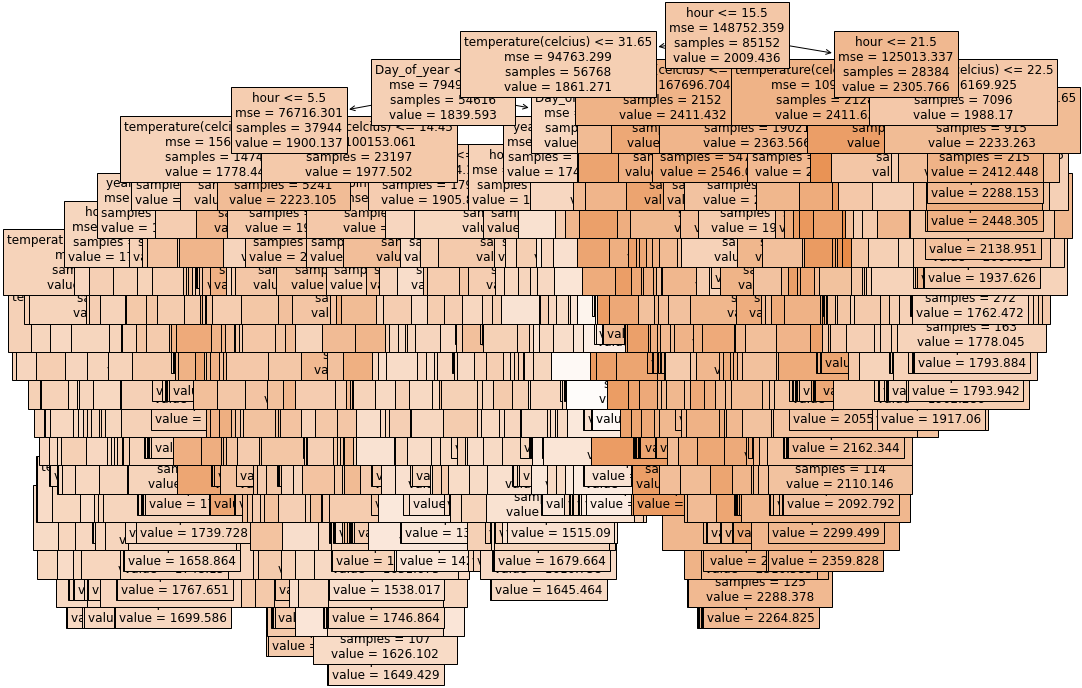

In [262]:
fig = plt.figure(figsize=(16,12))
a_rf_smote = plot_tree(grid_dtree.best_estimator_, feature_names=X_train.columns, fontsize=12, filled=True, class_names=['0', '1'])

In [263]:
y_pred_tree = pd.DataFrame(y_pred_tree)
predict_table_tree = pd.DataFrame(y_test)
predict_table_tree.insert(1,'predict',y_pred_tree)
predict_table_tree

,Operational Demand (MW),predict
timestamp,,
2021-12-01 00:00:00,1788.716,1713.526493
2021-12-01 00:30:00,1768.478,1713.526493
2021-12-01 01:00:00,1756.662,1713.526493
2021-12-01 01:30:00,1735.248,1713.526493
2021-12-01 02:00:00,1724.418,1713.526493
...,...,...
2022-03-31 21:30:00,2496.326,2361.296467
2022-03-31 22:00:00,2418.866,1937.626371
2022-03-31 22:30:00,2323.210,1937.626371


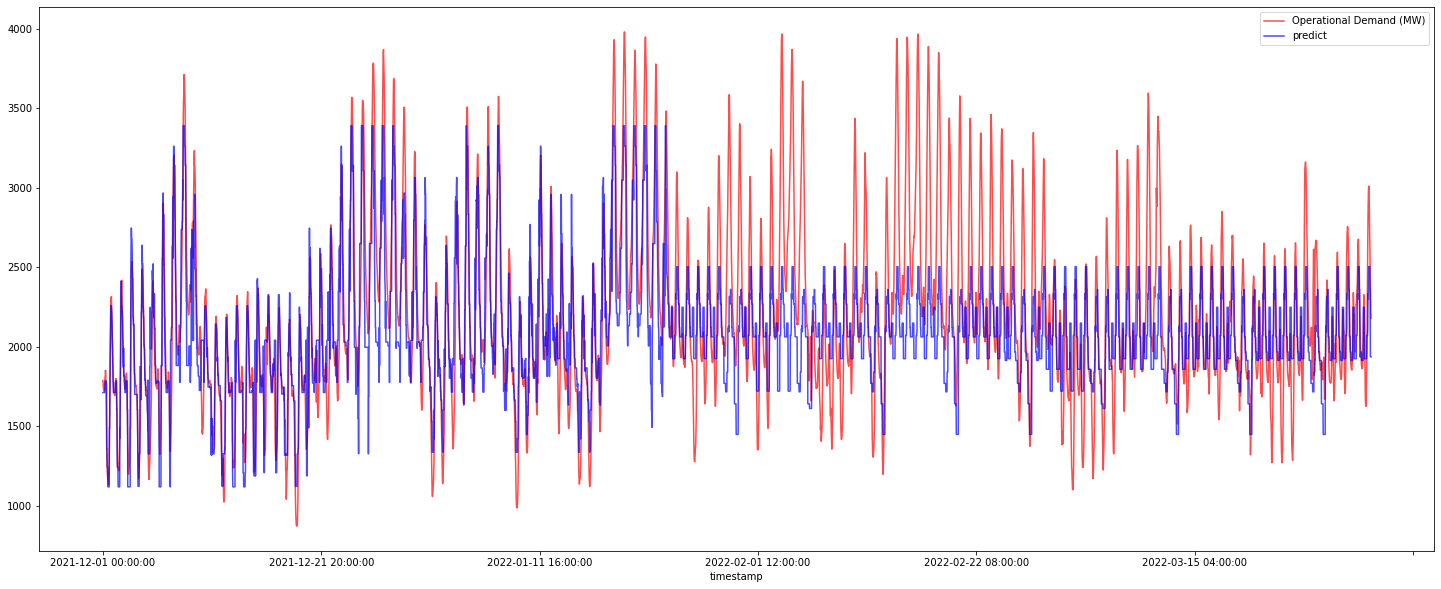

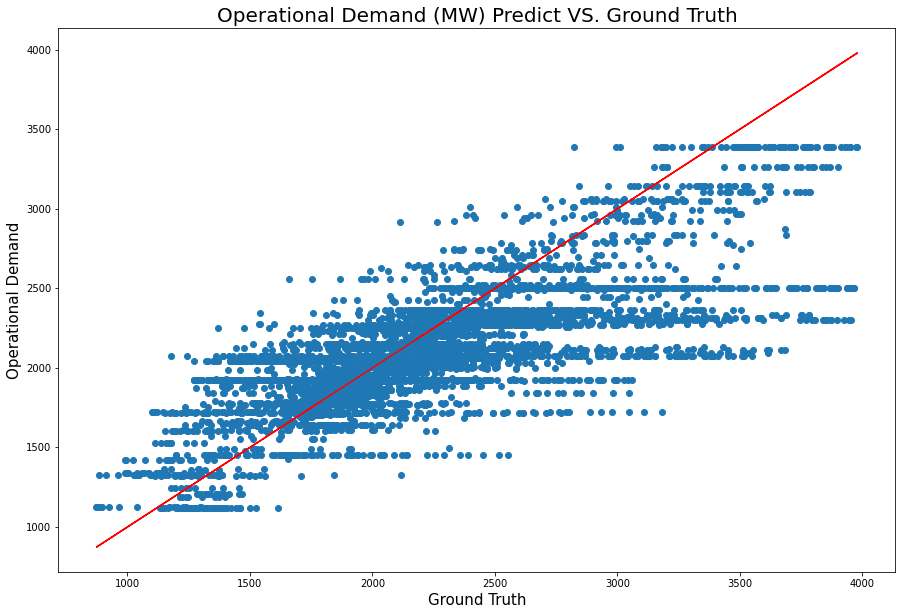

In [264]:
predict_table_tree.plot.line(figsize = (25,10), color = ['red','blue'],alpha = 0.7)
plt.show()
plt.figure(figsize=(15,10))
plt.scatter(predict_table_tree['Operational Demand (MW)'], predict_table_tree['predict'])
plt.plot(predict_table_tree['Operational Demand (MW)'],predict_table_tree['Operational Demand (MW)'], c= 'red')
plt.xlabel('Ground Truth',fontsize = 15)
plt.ylabel("Operational Demand", fontsize = 15)
plt.title("Operational Demand (MW) Predict VS. Ground Truth", fontsize = 20)
plt.show()

In [265]:
predict_table_tree['Date','time'] = predict_table_tree.index.str.split(" ",expand=True)
predict_table_tree[['Date', 'time']] = predict_table_tree[('Date', 'time')].apply(pd.Series)

predict_table_tree = predict_table_tree.drop(labels=['time',('Date','time')], axis=1)
agg_tree = pd.DataFrame(predict_table_tree.groupby(['Date'])['Operational Demand (MW)','predict'].sum().reset_index())


In [266]:
tree_plot = agg_tree.copy()
tree_plot.index = tree_plot['Date']
tree_plot.drop('Date',axis=1)

,Operational Demand (MW),predict
Date,,
2021-12-01,81389.002,81914.285393
2021-12-02,83692.208,81902.257928
2021-12-03,87674.768,86828.085950
2021-12-04,86230.014,86867.541120
2021-12-05,83724.146,90994.478198
...,...,...
2022-03-27,94461.504,89902.652239
2022-03-28,96458.404,101288.339552
2022-03-29,102975.830,101288.339552


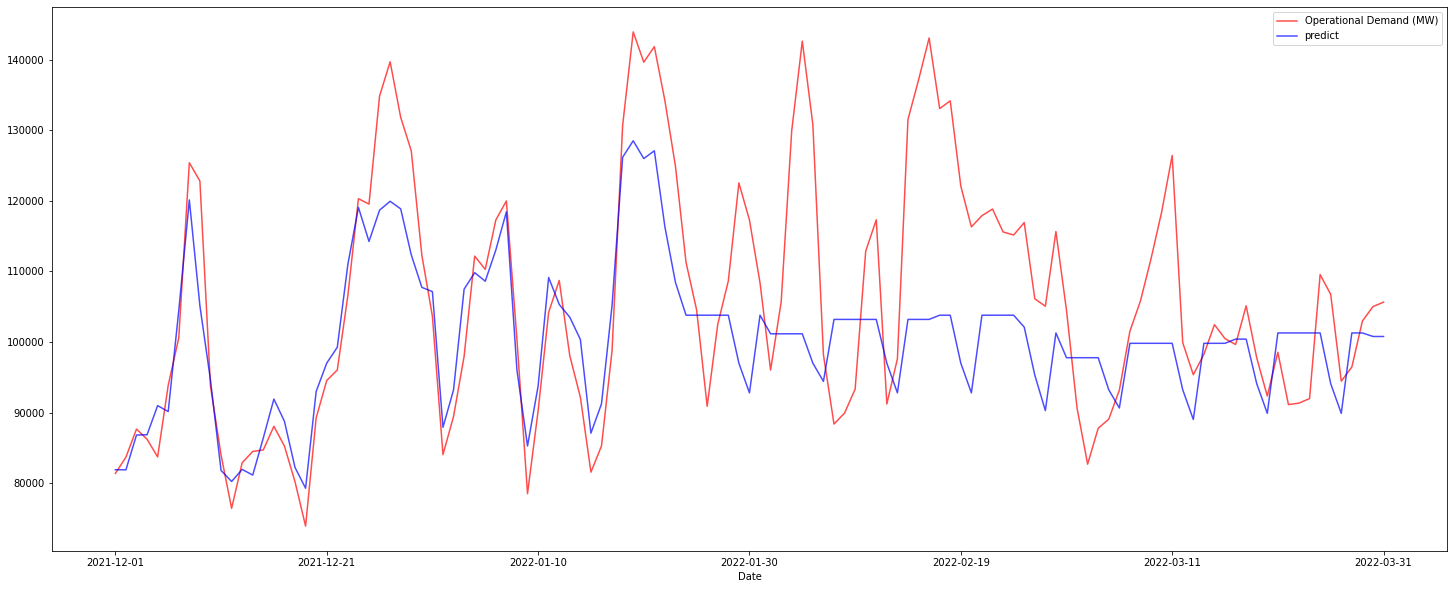

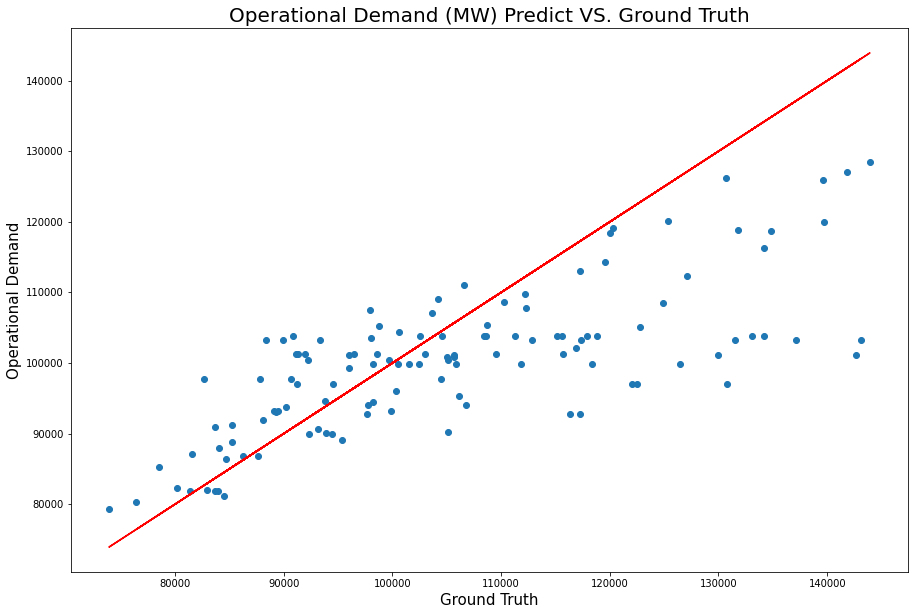

In [267]:
tree_plot.plot.line(figsize = (25,10), color = ['red','blue'],alpha = 0.7)
plt.show()
plt.figure(figsize=(15,10))
plt.scatter(tree_plot['Operational Demand (MW)'], tree_plot['predict'])
plt.plot(tree_plot['Operational Demand (MW)'],tree_plot['Operational Demand (MW)'], c= 'red')
plt.xlabel('Ground Truth',fontsize = 15)
plt.ylabel("Operational Demand", fontsize = 15)
plt.title("Operational Demand (MW) Predict VS. Ground Truth", fontsize = 20)
plt.show()

In [278]:
peak_day = 5 # number of top peak day we choose
peak_true = agg_tree.sort_values('Operational Demand (MW)',ascending=False)[:peak_day]
truelst = peak_true.index.tolist()
# peak_predict = agg_tree.sort_values('predict',ascending=False)[:peak_day]
peak_predict = agg_tree[agg_tree['predict'] > ave_threshold]
predictlst=peak_predict.index.tolist()
acc = len([x for x in truelst if x in predictlst])/peak_day
print('Accuracy for predicting peak 5 day:',acc)

Accuracy for predicting peak 5 day: 0.4


## Random Forest

In [269]:
forest = RandomForestRegressor(criterion='mse', random_state=42)

param_grid_forest = dict(
    max_depth =[None,15,20,25],
    min_samples_leaf=[5,50,100])

grid_forest=GridSearchCV(forest, param_grid_forest, cv=3, scoring='neg_root_mean_squared_error',verbose=2,return_train_score=True)

grid_forest.fit(X_train,y_train)
y_predict_forest = grid_forest.predict(X_test)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END .................max_depth=None, min_samples_leaf=5; total time=  13.9s
[CV] END .................max_depth=None, min_samples_leaf=5; total time=  14.3s
[CV] END .................max_depth=None, min_samples_leaf=5; total time=  13.8s
[CV] END ................max_depth=None, min_samples_leaf=50; total time=   9.7s
[CV] END ................max_depth=None, min_samples_leaf=50; total time=   9.5s
[CV] END ................max_depth=None, min_samples_leaf=50; total time=   9.5s
[CV] END ...............max_depth=None, min_samples_leaf=100; total time=   8.5s
[CV] END ...............max_depth=None, min_samples_leaf=100; total time=   8.7s
[CV] END ...............max_depth=None, min_samples_leaf=100; total time=   8.9s
[CV] END ...................max_depth=15, min_samples_leaf=5; total time=  12.2s
[CV] END ...................max_depth=15, min_samples_leaf=5; total time=  12.4s
[CV] END ...................max_depth=15, min_sa

In [270]:
ny_test = len(y_test)
mape = (sum(np.abs((y_test - y_predict_forest)/y_test))/ny_test)*100
print('Mape', mape)
rfscore=ModelScore(y_test,y_predict_forest)
rfscore
ImportanceDisplay('grid_forest')
print(grid_forest.best_estimator_)

Mape 10.093359657851426
Mean absolute error =  232.1101
Mean squared error =  120946.7119
Median absolute error =  143.7072
explained variance error =  0.652
R2 error =  0.617
+----------------------+--------+
|       Factors        | Score  |
+----------------------+--------+
|     humidity(%)      | 0.2069 |
|   wind_speed(mph)    | 0.0359 |
|     pressure(in)     | 0.0248 |
|     Day_of_month     | 0.0084 |
|     Day_of_year      | 0.0001 |
|    wind_gush(mph)    | 0.0034 |
|         year         | 0.0605 |
|         hour         | 0.015  |
| temperature(celcius) | 0.1011 |
|        minute        | 0.0415 |
|  dew_point(celcius)  | 0.4978 |
|     Day_of_week      | 0.0046 |
+----------------------+--------+
RandomForestRegressor(criterion='mse', max_depth=25, min_samples_leaf=5,
                      random_state=42)


In [271]:
y_predict_forest = pd.DataFrame(y_predict_forest)
predict_table_forest = pd.DataFrame(y_test)
predict_table_forest.insert(1,'predict',y_predict_forest)
predict_table_forest

,Operational Demand (MW),predict
timestamp,,
2021-12-01 00:00:00,1788.716,1756.073001
2021-12-01 00:30:00,1768.478,1750.116915
2021-12-01 01:00:00,1756.662,1736.688524
2021-12-01 01:30:00,1735.248,1733.223505
2021-12-01 02:00:00,1724.418,1728.939088
...,...,...
2022-03-31 21:30:00,2496.326,2333.219470
2022-03-31 22:00:00,2418.866,2139.026236
2022-03-31 22:30:00,2323.210,2125.414200


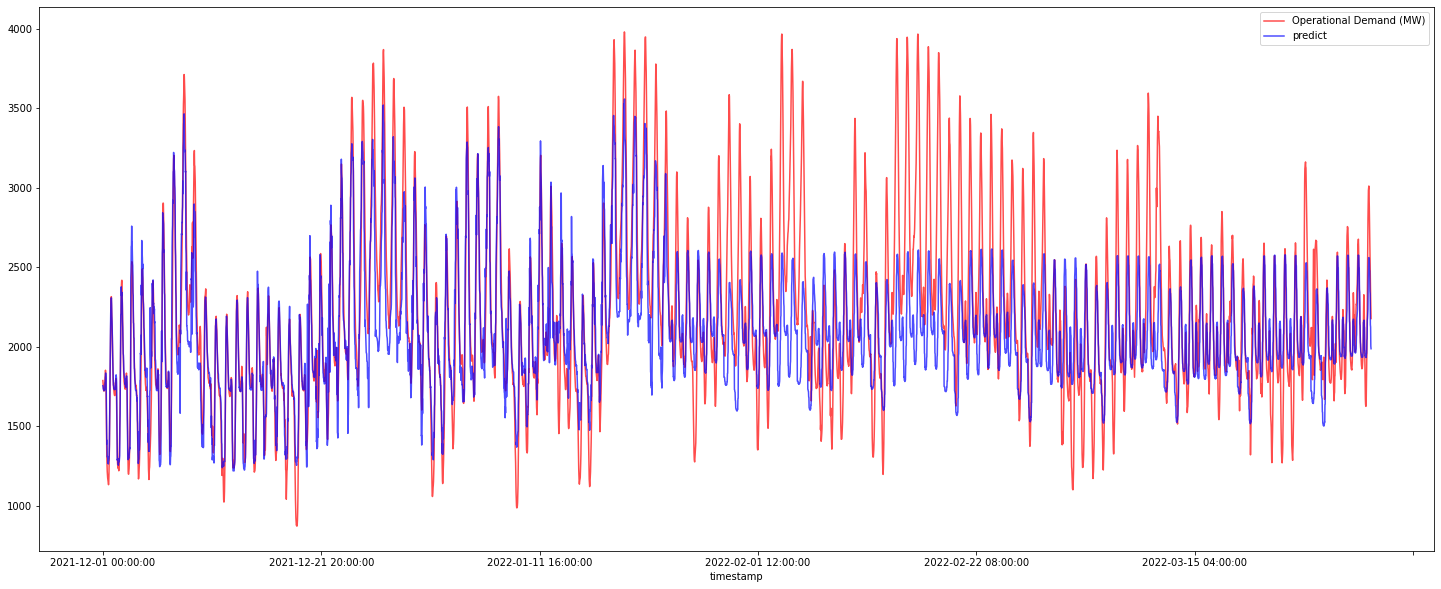

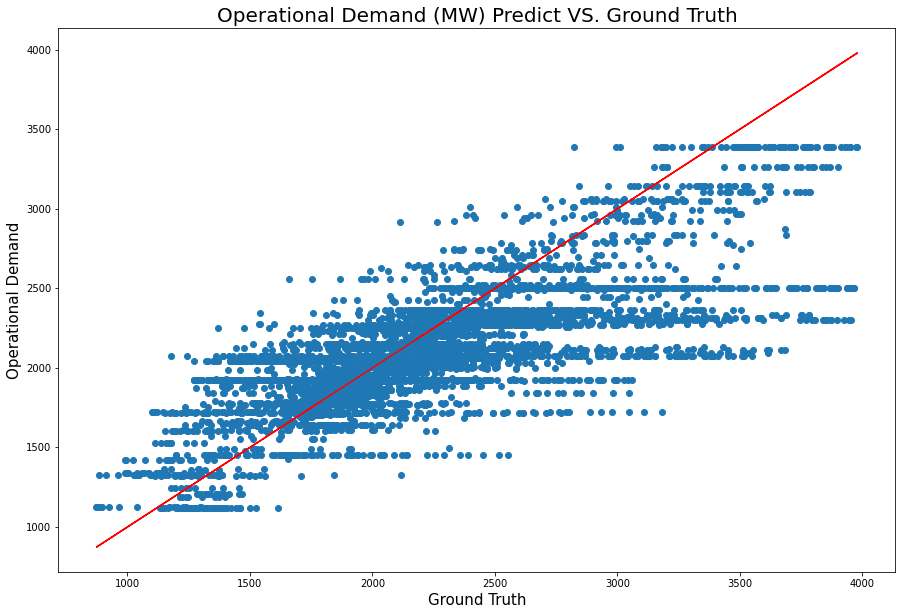

In [272]:
predict_table_forest.plot.line(figsize = (25,10), color = ['red','blue'],alpha = 0.7)
plt.show()
plt.figure(figsize=(15,10))
plt.scatter(predict_table_tree['Operational Demand (MW)'], predict_table_tree['predict'])
plt.plot(predict_table_tree['Operational Demand (MW)'],predict_table_tree['Operational Demand (MW)'], c= 'red')
plt.xlabel('Ground Truth',fontsize = 15)
plt.ylabel("Operational Demand", fontsize = 15)
plt.title("Operational Demand (MW) Predict VS. Ground Truth", fontsize = 20)
plt.show()

In [273]:
predict_table_forest['Date','time'] = predict_table_forest.index.str.split(" ",expand=True)
predict_table_forest[['Date', 'time']] = predict_table_forest[('Date', 'time')].apply(pd.Series)

predict_table_forest = predict_table_forest.drop(labels=['time',('Date','time')], axis=1)
agg_forest = pd.DataFrame(predict_table_forest.groupby(['Date'])['Operational Demand (MW)','predict'].sum().reset_index())

In [274]:
forest_plot = agg_forest.copy()
forest_plot.index = forest_plot['Date']
forest_plot.drop('Date',axis=1)

,Operational Demand (MW),predict
Date,,
2021-12-01,81389.002,83149.475710
2021-12-02,83692.208,84014.353222
2021-12-03,87674.768,89998.405175
2021-12-04,86230.014,90080.542426
2021-12-05,83724.146,91854.891495
...,...,...
2022-03-27,94461.504,90779.432980
2022-03-28,96458.404,101347.062220
2022-03-29,102975.830,102062.451055


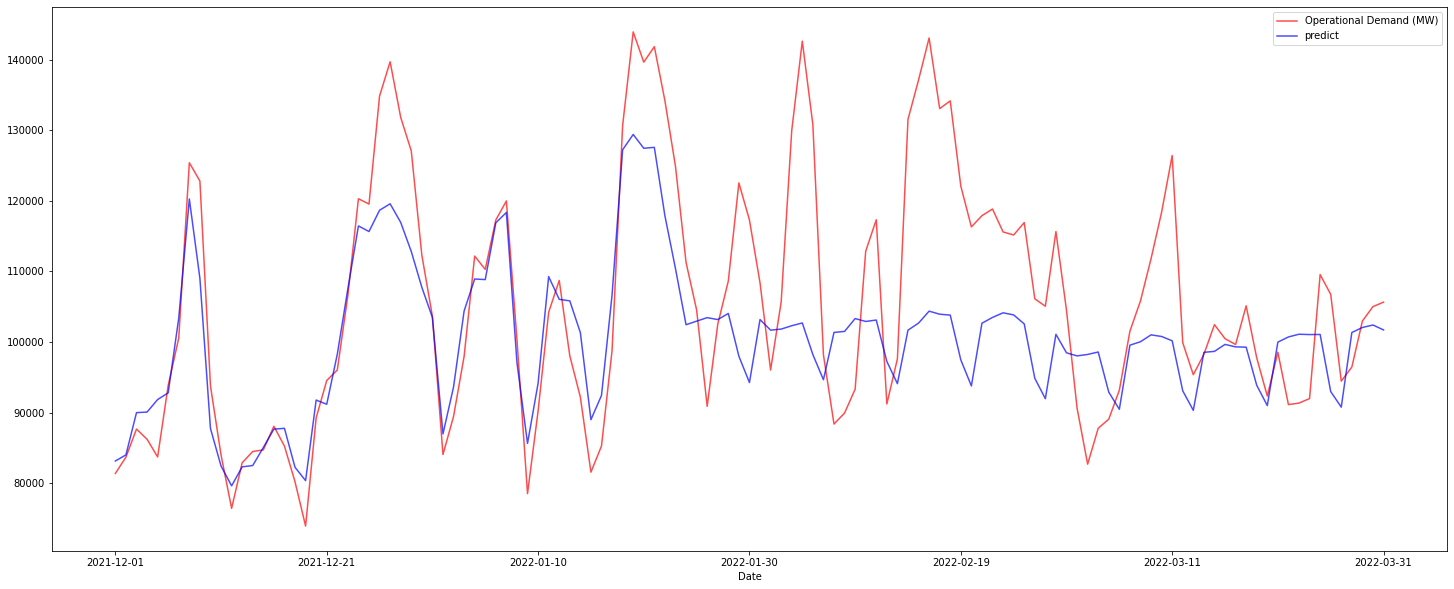

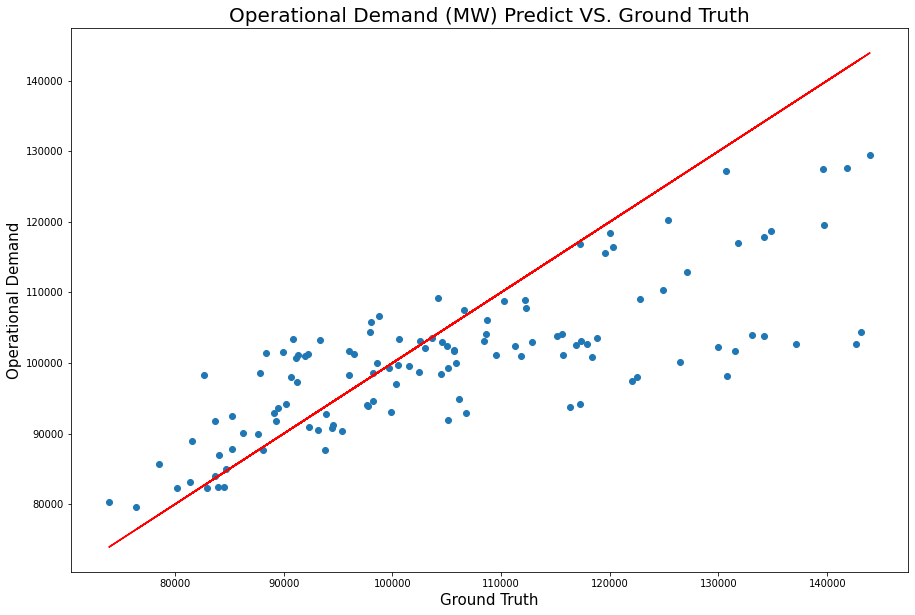

In [275]:
forest_plot.plot.line(figsize = (25,10), color = ['red','blue'],alpha = 0.7)
plt.show()
plt.figure(figsize=(15,10))
plt.scatter(forest_plot['Operational Demand (MW)'], forest_plot['predict'])
plt.plot(forest_plot['Operational Demand (MW)'],forest_plot['Operational Demand (MW)'], c= 'red')
plt.xlabel('Ground Truth',fontsize = 15)
plt.ylabel("Operational Demand", fontsize = 15)
plt.title("Operational Demand (MW) Predict VS. Ground Truth", fontsize = 20)
plt.show()

In [279]:
peak_day = 5 # number of top peak day we choose
peak_true = agg_forest.sort_values('Operational Demand (MW)',ascending=False)[:peak_day]
truelst = peak_true.index.tolist()
# peak_predict = agg_forest.sort_values('predict',ascending=False)[:peak_day]
peak_predict = agg_forest[agg_forest['predict'] > ave_threshold]
predictlst=peak_predict.index.tolist()
acc = len([x for x in truelst if x in predictlst])/peak_day
print('Accuracy for predicting peak 5 day:',acc)

Accuracy for predicting peak 5 day: 0.4
